In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

In [ ]:
# Set the path to the dataset
dataset_path = '/content/drive/MyDrive/AI&ML --- Level 6 /Assignment Folder/Fruit Classification'
train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')

In [ ]:
# Image size
img_height, img_width = 224, 224

# 3.1 PART A: IMPLEMENTING CONVOLUTIONAL NEURAL NETWORK FROM SCRATCH

In [ ]:
# 3.1.1 Data Understanding, Analysis, Visualization and Cleaning
print("3.1.1 DATA UNDERSTANDING, ANALYSIS, VISUALIZATION AND CLEANING")

# Get the list of classes from Train directory
classes = sorted(os.listdir(train_path))
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

3.1.1 DATA UNDERSTANDING, ANALYSIS, VISUALIZATION AND CLEANING
Number of classes: 5
Classes: ['Banana', 'Cherry', 'Grape', 'Mango', 'Peach']


In [ ]:
# Verify that test image classes are present in Train directory
expected_classes = {'Mango', 'Grape', 'Banana', 'Peach', 'Cherry'}
if not expected_classes.issubset(set(classes)):
    missing = expected_classes - set(classes)
    raise ValueError(f"Missing classes in Train directory: {missing}")

In [ ]:
# Collect all training images and their labels
image_paths = []
labels = []
for cls in classes:
    cls_path = os.path.join(train_path, cls)
    if os.path.exists(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            image_paths.append(img_path)
            labels.append(cls)
    else:
        print(f"Warning: Directory {cls_path} does not exist.")

In [ ]:
# Convert labels to numerical indices
label_to_index = {cls: idx for idx, cls in enumerate(classes)}
labels_numeric = [label_to_index[label] for label in labels]

# Perform 80-20 train-validation split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_numeric, test_size=0.2, stratify=labels_numeric, random_state=42
)

In [ ]:
# Count the number of images in each class for training and validation
train_counts = {cls: 0 for cls in classes}
val_counts = {cls: 0 for cls in classes}

for label in train_labels:
    train_counts[classes[label]] += 1
for label in val_labels:
    val_counts[classes[label]] += 1

print("Training set distribution:")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")

print("Validation set distribution:")
for cls, count in val_counts.items():
    print(f"{cls}: {count}")

Training set distribution:
Banana: 1137
Cherry: 986
Grape: 1174
Mango: 726
Peach: 978
Validation set distribution:
Banana: 285
Cherry: 246
Grape: 294
Mango: 182
Peach: 244


In [ ]:
# List of test images with their class labels
test_images = [
    '11_100.jpg',
    '14_100.jpg',
    '1_100(2).jpg',
    '26_100.jpg',
    '5_100.jpg'
]
test_labels_dict = {
    '11_100.jpg': 'Mango',
    '14_100.jpg': 'Grape',
    '1_100(2).jpg': 'Banana',
    '26_100.jpg': 'Peach',
    '5_100.jpg': 'Cherry'
}
test_image_paths = [os.path.join(test_path, img) for img in test_images]

In [ ]:
# Count test images per class
test_counts = {cls: 0 for cls in classes}
for img in test_images:
    cls = test_labels_dict[img]
    test_counts[cls] += 1

print("Test set distribution:")
for cls, count in test_counts.items():
    print(f"{cls}: {count}")

# Total number of images
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = len(test_images)
print(f"Total training images: {total_train}")
print(f"Total validation images: {total_val}")
print(f"Total test images: {total_test}")
print(f"Total images in dataset: {total_train + total_val + total_test}")

Test set distribution:
Banana: 1
Cherry: 1
Grape: 1
Mango: 1
Peach: 1
Total training images: 5001
Total validation images: 1251
Total test images: 5
Total images in dataset: 6257


Dataset represents a collection of fruit images categorized into different classes for classification.
The dataset is split into 80% training and 20% validation from the Train folder, with manually specified test images.


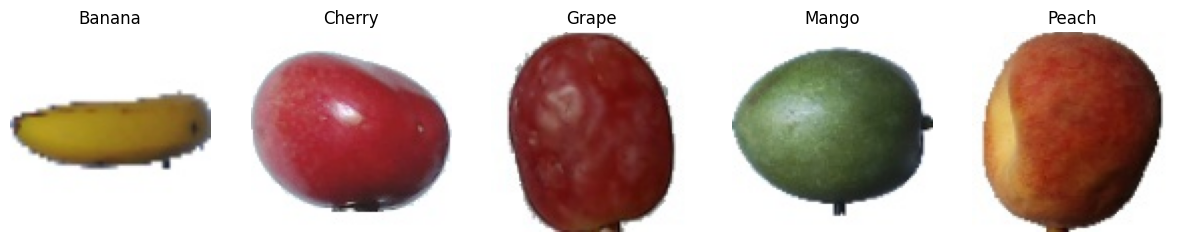

In [ ]:
# Description of dataset
print("Dataset represents a collection of fruit images categorized into different classes for classification.")
print("The dataset is split into 80% training and 20% validation from the Train folder, with manually specified test images.")

# Visualize sample images from training set
sample_images = []
for cls in classes:
    cls_path = os.path.join(train_path, cls)
    if os.path.exists(cls_path) and os.listdir(cls_path):
        img_name = os.listdir(cls_path)[0]
        img_path = os.path.join(cls_path, img_name)
        img = load_img(img_path)
        sample_images.append(img)
    else:
        print(f"No images found in {cls_path}")

if sample_images:
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(sample_images):
        plt.subplot(1, num_classes, i+1)
        plt.imshow(img)
        plt.title(classes[i])
        plt.axis('off')
    plt.show()

In [ ]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create dataframes for train and validation
train_df = pd.DataFrame({'filename': train_paths, 'class': [classes[label] for label in train_labels]})
val_df = pd.DataFrame({'filename': val_paths, 'class': [classes[label] for label in val_labels]})

In [ ]:
# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

Found 5001 validated image filenames belonging to 5 classes.
Found 1251 validated image filenames belonging to 5 classes.


In [ ]:
# Load test images manually
test_images_array = []
test_labels = []
for img_path, img_name in zip(test_image_paths, test_images):
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize
        test_images_array.append(img_array)
        # Convert class name to index
        cls = test_labels_dict[img_name]
        label = classes.index(cls)
        test_labels.append(label)
    else:
        print(f"Warning: Test image {img_path} not found.")

test_images_array = np.array(test_images_array)
test_labels = np.array(test_labels)

# Convert test labels to one-hot encoding for evaluation
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes)

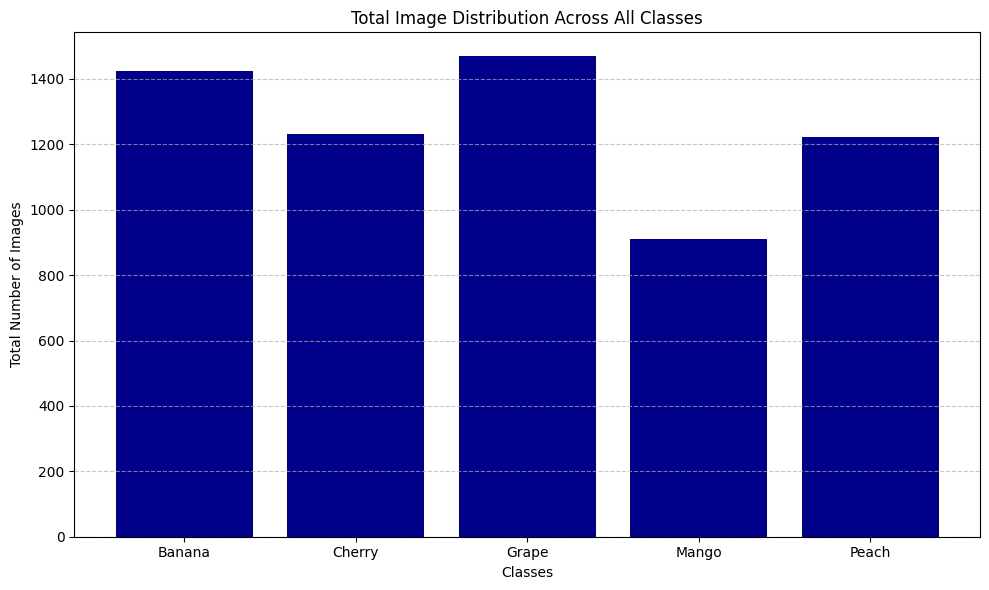

In [ ]:
# Plotting the total class distribution
plt.figure(figsize=(10, 6))

# Calculate total counts for each class
total_counts = {cls: train_counts.get(cls, 0) + val_counts.get(cls, 0) + test_counts.get(cls, 0) for cls in classes}

plt.bar(classes, [total_counts[cls] for cls in classes], color='darkblue')

plt.xlabel('Classes')
plt.ylabel('Total Number of Images')
plt.title('Total Image Distribution Across All Classes')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

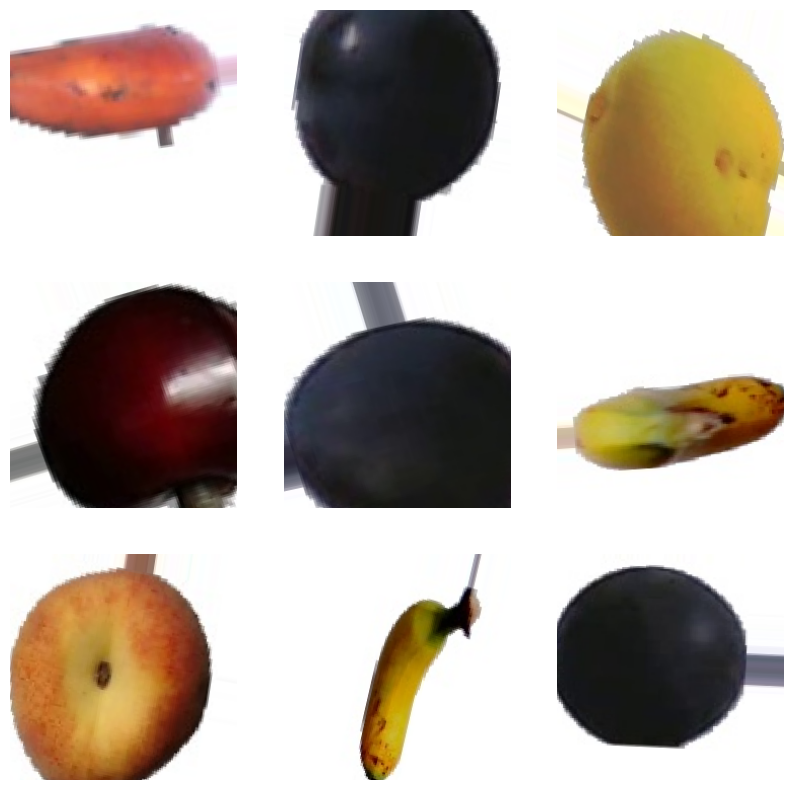

Preprocessing: Images resized to 224x224, pixel values normalized to [0,1].
Data augmentation: Rotation, shifts, shear, zoom, and horizontal flip applied for training.


In [ ]:
# Convert test labels to one-hot encoding for evaluation
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes)

# Visualize augmented images
augmented_images, _ = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

# Preprocessing techniques applied
print("Preprocessing: Images resized to 224x224, pixel values normalized to [0,1].")
print("Data augmentation: Rotation, shifts, shear, zoom, and horizontal flip applied for training.")

# 3.1.2 Design, Train, and Evaluate a Baseline Model  

In [ ]:
# Define the baseline model
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Print model summary
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,560,965 (169.99 MB)

 Trainable params: 44,560,965 (169.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 2. Model Training
print("2. Model Training")

# Compile the model
baseline_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
epochs = 10
history_baseline = baseline_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

2. Model Training


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1290s 8s/step - accuracy: 0.7090 - loss: 0.7477 - val_accuracy: 0.9488 - val_loss: 0.1388
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.9674 - loss: 0.0998 - val_accuracy: 0.9992 - val_loss: 0.0075
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 637ms/step - accuracy: 0.9755 - loss: 0.0760 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 527ms/step - accuracy: 0.9954 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 1.9433e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.9910 - loss: 0.0333 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.9882 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.9930 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 6.9130e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step - accuracy: 0.9970 -

In [ ]:
# Save the model, not the history
baseline_model.save("baseline_model.h5")

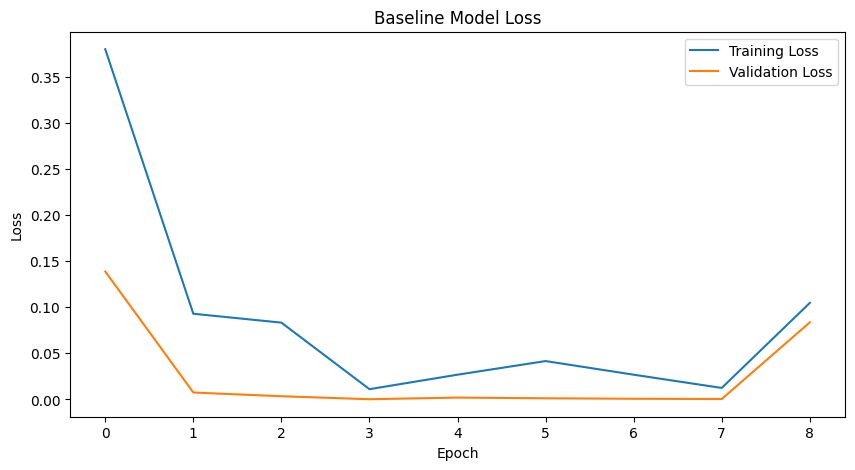

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 3. Model Evaluation
print("3. Model Evaluation")

# Evaluate the model on test images
test_loss, test_acc = baseline_model.evaluate(test_images_array, test_labels_one_hot)
print(f"Test Accuracy: {test_acc}")

# Get predictions
y_pred = baseline_model.predict(test_images_array)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=classes))

3. Model Evaluation
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - accuracy: 1.0000 - loss: 2.9802e-06
Test Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       1.00      1.00      1.00         1
       Mango       1.00      1.00      1.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



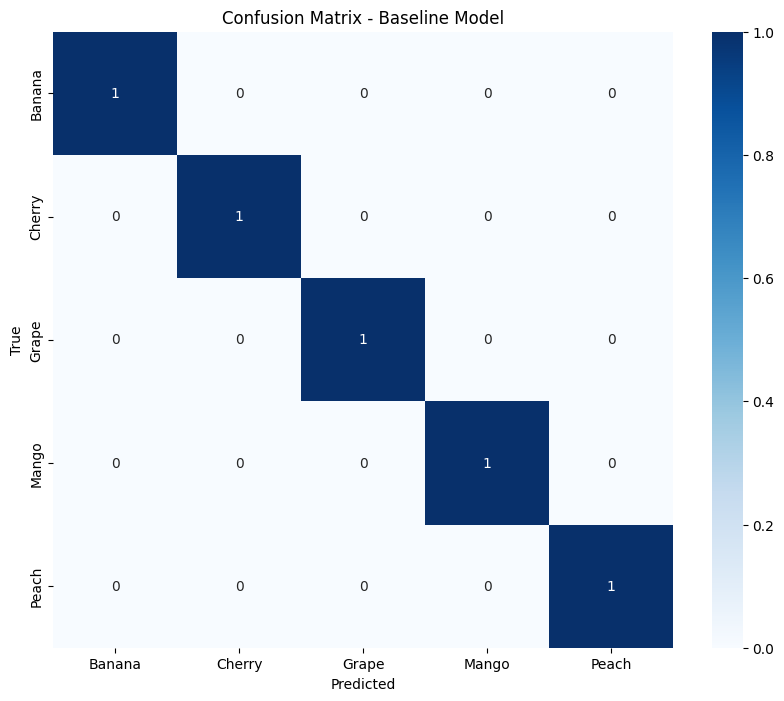

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


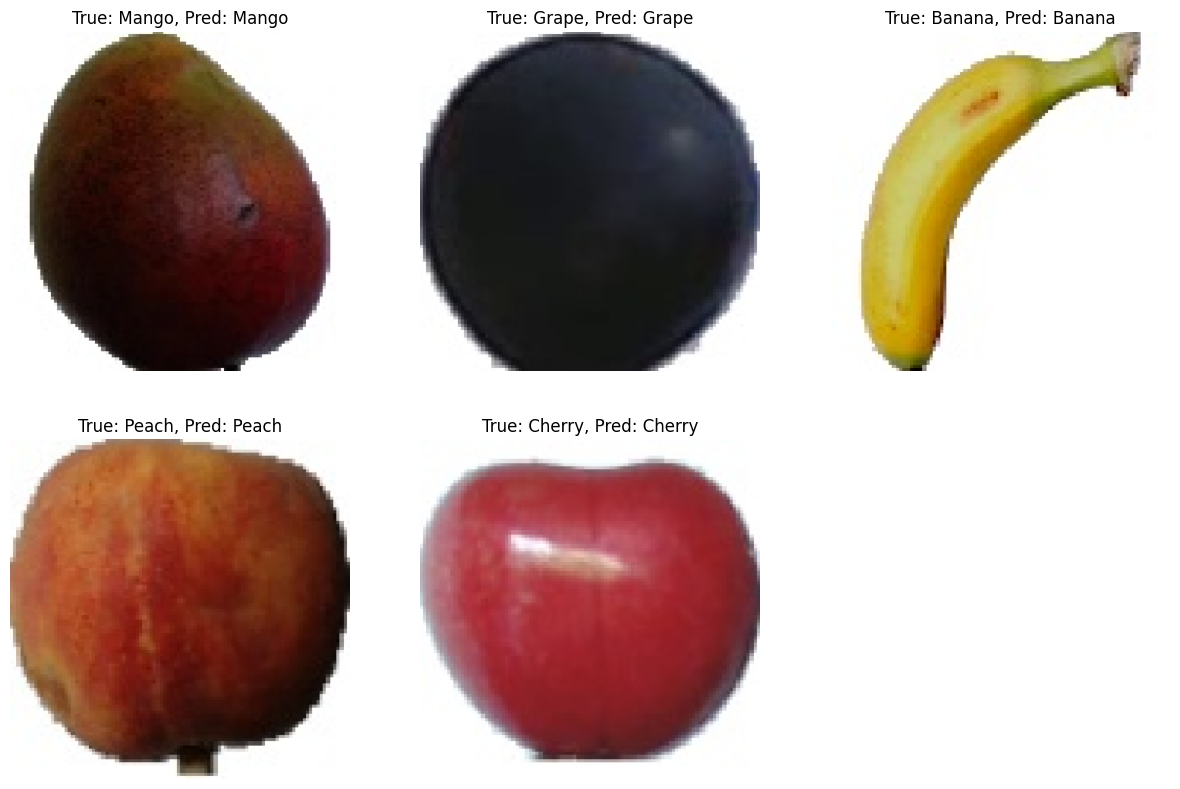

Observations: Baseline model with early stopping and larger validation set reduces overfitting.


In [ ]:
# Perform inference on test images
predictions = baseline_model.predict(test_images_array)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 15))
for i in range(min(5, len(test_images_array))):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images_array[i])
    plt.title(f"True: {classes[y_true[i]]}, Pred: {classes[predicted_classes[i]]}")
    plt.axis('off')
plt.show()

print("Observations: Baseline model with early stopping and larger validation set reduces overfitting.")

# 3.1.3 Design, Train, and Evaluate Deeper Architecture with Regularization Layer  

In [ ]:
# 1. Model Architecture
print("1. Model Architecture")

# Define the deeper model
deeper_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Print model summary
deeper_model.summary()

1. Model Architecture


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,430,085 (74.12 MB)

 Trainable params: 19,429,125 (74.12 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# 2. Model Training
print("2. Model Training")

# Compile the model
deeper_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_deeper = deeper_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

2. Model Training
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 584ms/step - accuracy: 0.5318 - loss: 7.3361 - val_accuracy: 0.2982 - val_loss: 8.4867
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.8058 - loss: 1.7136 - val_accuracy: 0.4964 - val_loss: 1.3950
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 527ms/step - accuracy: 0.8605 - loss: 0.9659 - val_accuracy: 0.9424 - val_loss: 0.1940
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step - accuracy: 0.9209 - loss: 0.4194 - val_accuracy: 0.9816 - val_loss: 0.0528
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.9382 - loss: 0.3699 - val_accuracy: 0.9233 - val_loss: 0.5520
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step - accuracy: 0.9325 - loss: 0.2940 - val_accuracy: 0.8929 - val_loss: 0.6297
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step - accuracy: 0.9348 - loss: 0.2527 - val_accuracy: 0.7242 - val_loss: 9.7710
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accurac

In [ ]:
deeper_model.save("history_model.h5") # Save the model, not the history

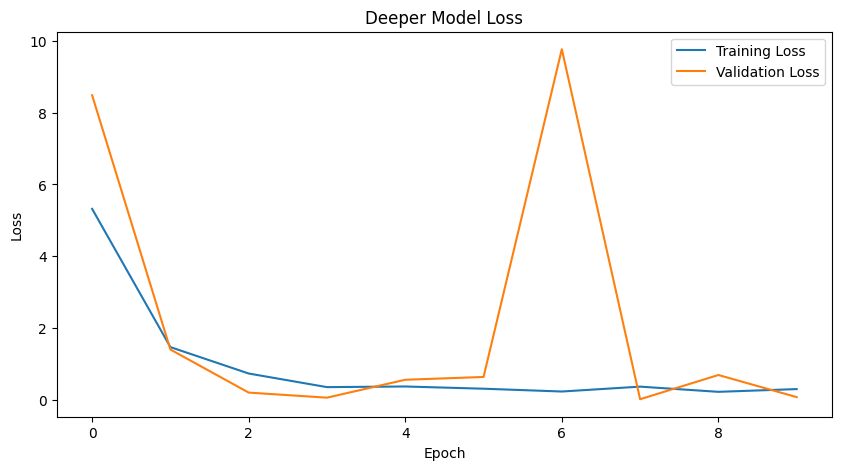

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_deeper.history['loss'], label='Training Loss')
plt.plot(history_deeper.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

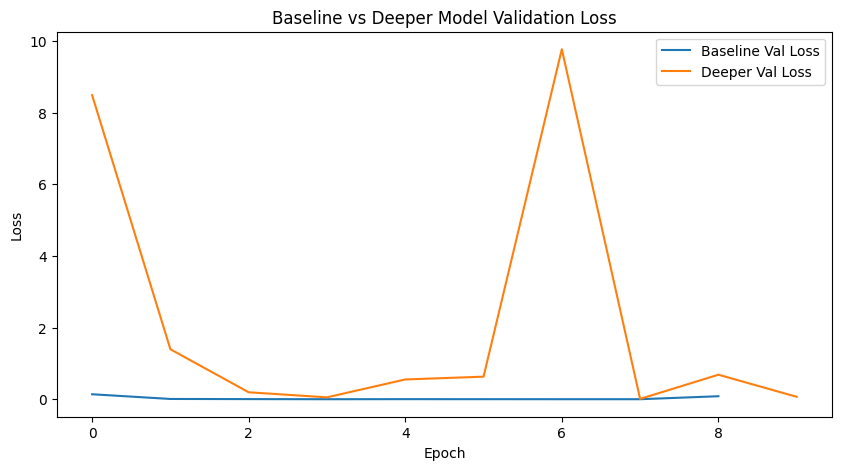

In [ ]:
# Compare with baseline
plt.figure(figsize=(10, 5))
plt.plot(history_baseline.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_deeper.history['val_loss'], label='Deeper Val Loss')
plt.title('Baseline vs Deeper Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 3. Model Evaluation
print("3. Model Evaluation")

# Evaluate the model
test_loss_deeper, test_acc_deeper = deeper_model.evaluate(test_images_array, test_labels_one_hot)
print(f"Test Accuracy: {test_acc_deeper}")

# Get predictions
y_pred_deeper = deeper_model.predict(test_images_array)
y_pred_classes_deeper = np.argmax(y_pred_deeper, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes_deeper, target_names=classes))

3. Model Evaluation
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - accuracy: 1.0000 - loss: 2.3842e-08
Test Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       1.00      1.00      1.00         1
       Mango       1.00      1.00      1.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



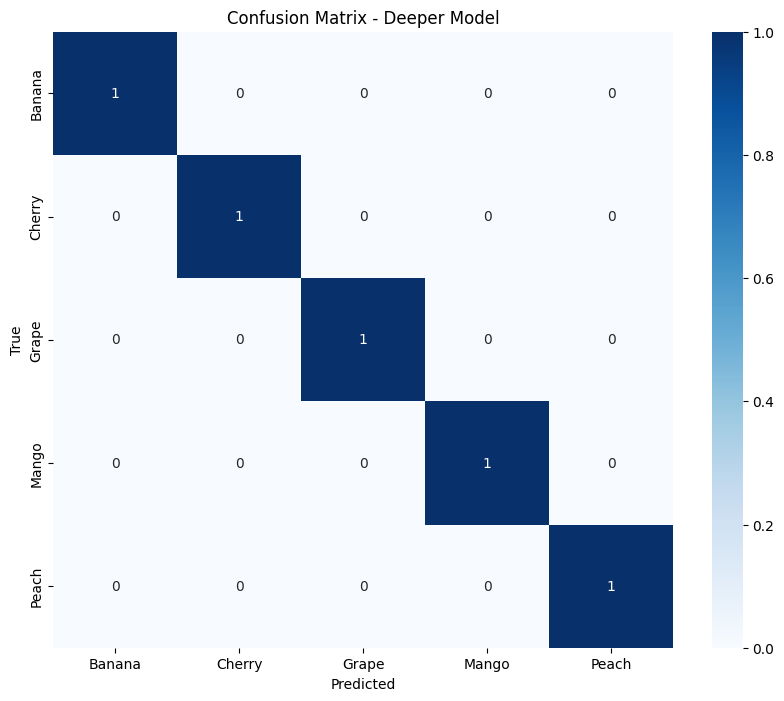

Improvements: Deeper model with regularization and larger validation set further reduces overfitting.


In [ ]:
# Confusion matrix
cm_deeper = confusion_matrix(y_true, y_pred_classes_deeper)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_deeper, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Deeper Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Improvements: Deeper model with regularization and larger validation set further reduces overfitting.")

# 3.1.4 Experimentation and Comparative Analysis

In [ ]:
# 1. Baseline vs. Deeper Model Performance
print("1. Baseline vs. Deeper Model Performance")

print(f"Baseline Model Test Accuracy: {test_acc}")
print(f"Deeper Model Test Accuracy: {test_acc_deeper}")
print("Discussion: Deeper model typically improves accuracy due to increased capacity and regularization.")

1. Baseline vs. Deeper Model Performance
Baseline Model Test Accuracy: 1.0
Deeper Model Test Accuracy: 1.0
Discussion: Deeper model typically improves accuracy due to increased capacity and regularization.


In [ ]:
# 3. Optimizer Analysis: SGD vs Adam
print("3. Optimizer Analysis: SGD vs Adam")

# Train deeper model with SGD
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)
deeper_model_sgd = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

deeper_model_sgd.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_sgd = deeper_model_sgd.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

3. Optimizer Analysis: SGD vs Adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 539ms/step - accuracy: 0.3446 - loss: 3.6194 - val_accuracy: 0.2350 - val_loss: 1.5978
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 532ms/step - accuracy: 0.2321 - loss: 1.7439 - val_accuracy: 0.2350 - val_loss: 1.5966
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 528ms/step - accuracy: 0.2215 - loss: 1.6020 - val_accuracy: 0.2350 - val_loss: 1.5965
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 523ms/step - accuracy: 0.2360 - loss: 1.6062 - val_accuracy: 0.2278 - val_loss: 1.5968
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.2339 - loss: 1.6156 - val_accuracy: 0.2350 - val_loss: 1.5967
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.2323 - loss: 1.5991 - val_accuracy: 0.2350 - val_loss: 1.5967
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.2237 - loss: 1.6203 - val_accuracy: 0.2350 - val_loss: 1.5966
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.2399 - loss: 

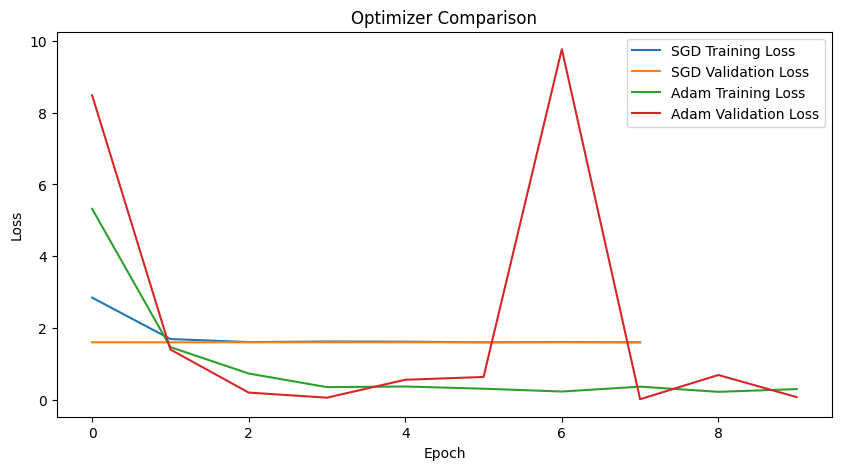

Adam converges faster than SGD due to adaptive learning rates.


In [ ]:
# Plot loss curves for SGD and Adam
plt.figure(figsize=(10, 5))
plt.plot(history_sgd.history['loss'], label='SGD Training Loss')
plt.plot(history_sgd.history['val_loss'], label='SGD Validation Loss')
plt.plot(history_deeper.history['loss'], label='Adam Training Loss')
plt.plot(history_deeper.history['val_loss'], label='Adam Validation Loss')
plt.title('Optimizer Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Adam converges faster than SGD due to adaptive learning rates.")

In [ ]:
# 4. Challenges and Observations
print("4. Challenges and Observations")

print("Challenges: Overfitting mitigated by larger validation set, regularization, and early stopping.")
print("Hardware: Google Colab GPU used for faster training.")
print("Observation: Deeper model with Adam and early stopping performs best with reduced overfitting.")

4. Challenges and Observations
Challenges: Overfitting mitigated by larger validation set, regularization, and early stopping.
Hardware: Google Colab GPU used for faster training.
Observation: Deeper model with Adam and early stopping performs best with reduced overfitting.


# 3.2 PART B: FINE-TUNING A PRE-TRAINED MODEL (TRANSFER LEARNING)

In [ ]:
# 3.2.1 Loading and Adapting a Pre-Trained Model
print("3.2.1 Loading and Adapting a Pre-Trained Model")

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

3.2.1 Loading and Adapting a Pre-Trained Model
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 3.2.2 Model Training and Fine-Tuning
print("3.2.2 Model Training and Fine-Tuning")

# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using feature extraction
history_transfer = transfer_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

3.2.2 Model Training and Fine-Tuning
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 126s 707ms/step - accuracy: 0.2485 - loss: 1.6829 - val_accuracy: 0.4700 - val_loss: 1.2806
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 562ms/step - accuracy: 0.4517 - loss: 1.3455 - val_accuracy: 0.7490 - val_loss: 0.8934
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 575ms/step - accuracy: 0.5820 - loss: 1.0593 - val_accuracy: 0.8785 - val_loss: 0.6734
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 559ms/step - accuracy: 0.6941 - loss: 0.8421 - val_accuracy: 0.9464 - val_loss: 0.4790
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 89s 567ms/step - accuracy: 0.7740 - loss: 0.6776 - val_accuracy: 0.9369 - val_loss: 0.3676
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 580ms/step - accuracy: 0.8274 - loss: 0.5313 - val_accuracy: 0.9536 - val_loss: 0.2718
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 87s 553ms/step - accuracy: 0.8628 - loss: 0.4287 - val_accuracy: 0.9592 - val_loss: 0.2198
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 5

In [ ]:
transfer_model.save("history_transfer_model.h5") # Save the model, not the history

In [ ]:
# Evaluate the model
test_loss_transfer, test_acc_transfer = transfer_model.evaluate(test_images_array, test_labels_one_hot)
print(f"Test Accuracy: {test_acc_transfer}")

# Get predictions
y_pred_transfer = transfer_model.predict(test_images_array)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes_transfer, target_names=classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0427
Test Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       1.00      1.00      1.00         1
       Mango       1.00      1.00      1.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



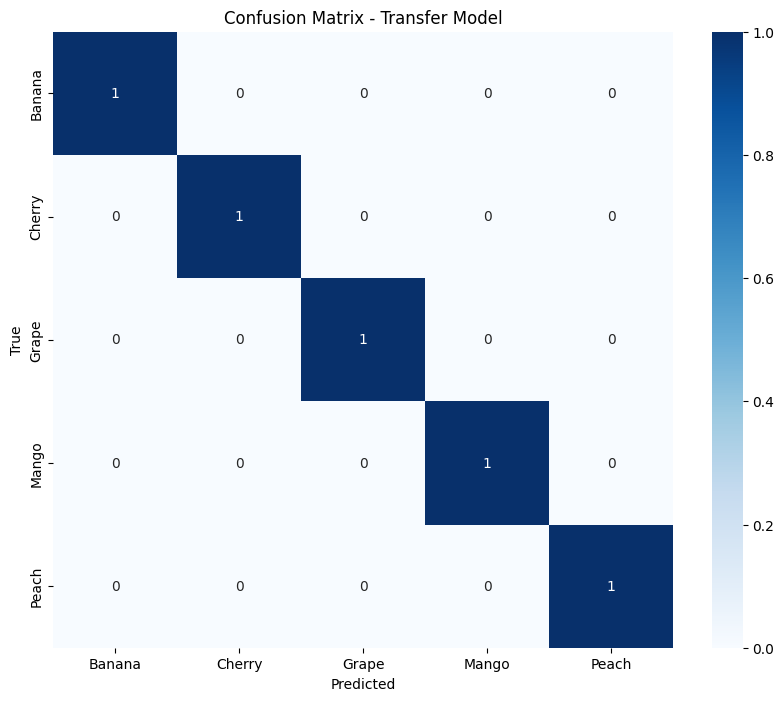

In [ ]:
# Confusion matrix
cm_transfer = confusion_matrix(y_true, y_pred_classes_transfer)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Transfer Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Compare with Part A models
print(f"Baseline Model Test Accuracy: {test_acc}")
print(f"Deeper Model Test Accuracy: {test_acc_deeper}")
print(f"Transfer Learning Model Test Accuracy: {test_acc_transfer}")
print("Transfer learning outperforms scratch models due to pre-trained feature extraction.")

Baseline Model Test Accuracy: 1.0
Deeper Model Test Accuracy: 1.0
Transfer Learning Model Test Accuracy: 1.0
Transfer learning outperforms scratch models due to pre-trained feature extraction.


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/AI&ML --- Level 6 /Assignment Folder/history_transfer_model.h5')
print("Model Loaded Successfully")


Model Loaded Successfully


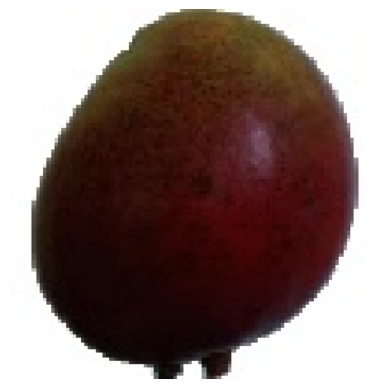

In [ ]:
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# Provide the URL of the image
image_path = '/content/drive/MyDrive/AI&ML --- Level 6 /Assignment Folder/Fruit Classification/Train/Mango/101_100(1).jpg'
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))  # Adjust size to your model's input
img_array = img_to_array(img) / 255.0  # Normalize if needed
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
print(model.input_shape)

(None, 224, 224, 3)


In [ ]:
prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[2.0030123e-04 9.6280937e-04 9.3855718e-03 8.6906838e-01 1.2038294e-01]]


In [ ]:
class_labels = [
    'Banana', 'Cherry', 'Grape', 'Mango', 'Peach'
]

predicted_class_index = np.argmax(prediction)
predicted_label = class_labels[predicted_class_index]
confidence_score = prediction[0][predicted_class_index] * 100
print("Predicted Label:", predicted_label)
print("Confidence Score: {:.2f}%".format(confidence_score))

Predicted Label: Mango
Confidence Score: 86.91%
